In [450]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['sample_submission.csv', 'plates.zip']
After zip extraction:
['val', '.ipynb_checkpoints', 'plates', 'submission.csv', 'train', '__notebook_source__.ipynb', '__MACOSX']


In [451]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['.DS_Store', 'test', 'train']


In [452]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0 or 1==2: #dda
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 2193.73it/s]


In [453]:
!ls train

cleaned  dirty


In [454]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

torch.manual_seed(0) # dda
np.random.seed(0)    # dda


from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), #dda
    transforms.ColorJitter(0.6, 0.6, 0.3, 0.3), #dda
    transforms.RandomRotation(50),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x[np.random.permutation(3), :, :]), #dda
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [455]:
len(train_dataloader), len(train_dataset)

(4, 32)

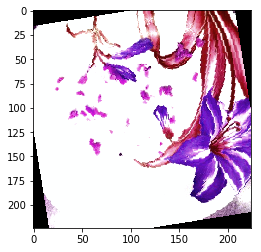

In [456]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

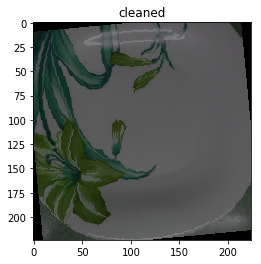

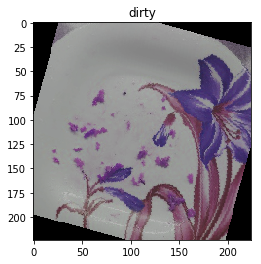

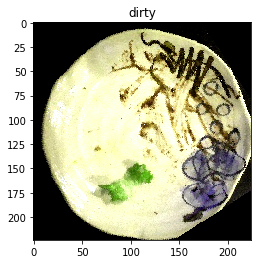

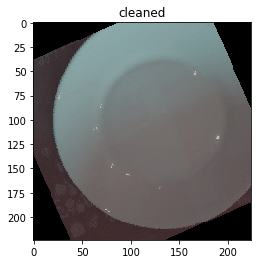

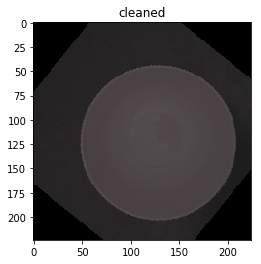

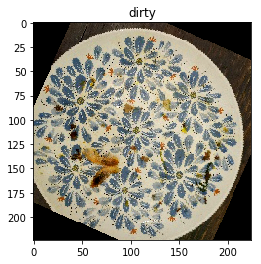

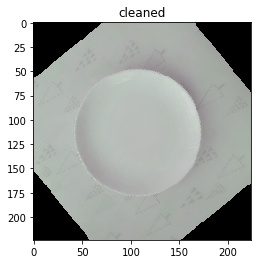

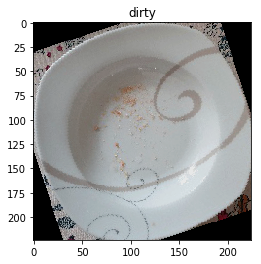

In [457]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [458]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        #for phase in ['train', 'val']: #dda
        for phase in ['train']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            #dda
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [459]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)          #dda
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  #dda

In [460]:
train_losses = []
train_accuracies = []

train_model(model, loss, optimizer, scheduler, num_epochs=87);

Epoch 0/99:


100%|██████████| 4/4 [00:04<00:00,  1.25s/it]

train Loss: 0.8461 Acc: 0.4375
Epoch 1/99:



100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

train Loss: 0.7537 Acc: 0.6250
Epoch 2/99:



100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

train Loss: 1.8180 Acc: 0.5625
Epoch 3/99:



100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

train Loss: 1.5476 Acc: 0.5625
Epoch 4/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 1.6882 Acc: 0.6250
Epoch 5/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 1.0896 Acc: 0.8125
Epoch 6/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.3539 Acc: 0.8438
Epoch 7/99:



100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

train Loss: 0.3069 Acc: 0.8750
Epoch 8/99:



100%|██████████| 4/4 [00:02<00:00,  1.73it/s]

train Loss: 0.6318 Acc: 0.7500
Epoch 9/99:



100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

train Loss: 0.9091 Acc: 0.7188
Epoch 10/99:



100%|██████████| 4/4 [00:02<00:00,  1.74it/s]

train Loss: 0.1572 Acc: 0.9688
Epoch 11/99:



100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

train Loss: 0.4259 Acc: 0.8750
Epoch 12/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.5618 Acc: 0.7812
Epoch 13/99:



100%|██████████| 4/4 [00:02<00:00,  1.71it/s]

train Loss: 0.4777 Acc: 0.8438
Epoch 14/99:



100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

train Loss: 0.3724 Acc: 0.8750
Epoch 15/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.4260 Acc: 0.8750
Epoch 16/99:



100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

train Loss: 0.2954 Acc: 0.9688
Epoch 17/99:



100%|██████████| 4/4 [00:02<00:00,  1.74it/s]

train Loss: 0.3434 Acc: 0.8125
Epoch 18/99:



100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

train Loss: 0.2583 Acc: 0.9062
Epoch 19/99:



100%|██████████| 4/4 [00:02<00:00,  1.72it/s]

train Loss: 0.1552 Acc: 0.9375
Epoch 20/99:



100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

train Loss: 0.1338 Acc: 0.9688
Epoch 21/99:



100%|██████████| 4/4 [00:02<00:00,  1.73it/s]

train Loss: 0.0931 Acc: 1.0000
Epoch 22/99:



100%|██████████| 4/4 [00:02<00:00,  1.71it/s]

train Loss: 0.3325 Acc: 0.9062
Epoch 23/99:



100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

train Loss: 0.4196 Acc: 0.8438
Epoch 24/99:



100%|██████████| 4/4 [00:02<00:00,  1.73it/s]

train Loss: 0.5013 Acc: 0.8125
Epoch 25/99:



100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

train Loss: 0.2924 Acc: 0.8438
Epoch 26/99:



100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

train Loss: 0.1851 Acc: 0.8438
Epoch 27/99:



100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

train Loss: 0.2407 Acc: 0.8750
Epoch 28/99:



100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

train Loss: 0.3031 Acc: 0.9062
Epoch 29/99:



100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

train Loss: 0.3925 Acc: 0.7812
Epoch 30/99:



100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

train Loss: 0.2770 Acc: 0.9062
Epoch 31/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.2348 Acc: 0.8750
Epoch 32/99:



100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

train Loss: 0.4095 Acc: 0.8125
Epoch 33/99:



100%|██████████| 4/4 [00:02<00:00,  1.71it/s]

train Loss: 0.3915 Acc: 0.9062
Epoch 34/99:



100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

train Loss: 0.4038 Acc: 0.9375
Epoch 35/99:



100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

train Loss: 0.1748 Acc: 0.8750
Epoch 36/99:



100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

train Loss: 0.2406 Acc: 0.9062
Epoch 37/99:



100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

train Loss: 0.3572 Acc: 0.8438
Epoch 38/99:



100%|██████████| 4/4 [00:02<00:00,  1.69it/s]

train Loss: 0.1824 Acc: 0.9375
Epoch 39/99:



100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

train Loss: 0.2036 Acc: 0.9062
Epoch 40/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.4566 Acc: 0.8125
Epoch 41/99:



100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

train Loss: 0.3955 Acc: 0.8750
Epoch 42/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.3982 Acc: 0.8438
Epoch 43/99:



100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

train Loss: 0.1918 Acc: 0.9688
Epoch 44/99:



100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

train Loss: 0.2476 Acc: 0.9062
Epoch 45/99:



100%|██████████| 4/4 [00:02<00:00,  1.71it/s]

train Loss: 0.7057 Acc: 0.8125
Epoch 46/99:



100%|██████████| 4/4 [00:02<00:00,  1.68it/s]

train Loss: 0.3572 Acc: 0.8125
Epoch 47/99:



100%|██████████| 4/4 [00:02<00:00,  1.68it/s]

train Loss: 0.2195 Acc: 0.8750
Epoch 48/99:



100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

train Loss: 0.6103 Acc: 0.7500
Epoch 49/99:



100%|██████████| 4/4 [00:02<00:00,  1.74it/s]

train Loss: 0.0370 Acc: 1.0000
Epoch 50/99:



100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

train Loss: 0.2863 Acc: 0.8750
Epoch 51/99:



100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

train Loss: 0.2198 Acc: 0.9062
Epoch 52/99:



100%|██████████| 4/4 [00:02<00:00,  1.73it/s]

train Loss: 0.4515 Acc: 0.8438
Epoch 53/99:



100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

train Loss: 0.1320 Acc: 0.9375
Epoch 54/99:



100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

train Loss: 0.5524 Acc: 0.8438
Epoch 55/99:



100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

train Loss: 0.4362 Acc: 0.8750
Epoch 56/99:



100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

train Loss: 0.3591 Acc: 0.8438
Epoch 57/99:



100%|██████████| 4/4 [00:02<00:00,  1.73it/s]

train Loss: 0.6860 Acc: 0.8438
Epoch 58/99:



100%|██████████| 4/4 [00:02<00:00,  1.68it/s]

train Loss: 0.2874 Acc: 0.8750
Epoch 59/99:



100%|██████████| 4/4 [00:02<00:00,  1.73it/s]

train Loss: 0.5901 Acc: 0.8438
Epoch 60/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.5107 Acc: 0.7812
Epoch 61/99:



100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

train Loss: 0.2331 Acc: 0.9375
Epoch 62/99:



100%|██████████| 4/4 [00:02<00:00,  1.74it/s]

train Loss: 0.1918 Acc: 0.9375
Epoch 63/99:



100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

train Loss: 0.4634 Acc: 0.8438
Epoch 64/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.3194 Acc: 0.9062
Epoch 65/99:



100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

train Loss: 0.4801 Acc: 0.8750
Epoch 66/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.1260 Acc: 0.9688
Epoch 67/99:



100%|██████████| 4/4 [00:02<00:00,  1.74it/s]

train Loss: 0.2545 Acc: 0.9062
Epoch 68/99:



100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

train Loss: 0.2157 Acc: 0.8125
Epoch 69/99:



100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

train Loss: 0.2883 Acc: 0.8438
Epoch 70/99:



100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

train Loss: 0.2498 Acc: 0.9062
Epoch 71/99:



100%|██████████| 4/4 [00:02<00:00,  1.74it/s]

train Loss: 0.1726 Acc: 0.9062
Epoch 72/99:



100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

train Loss: 0.3240 Acc: 0.8750
Epoch 73/99:



100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

train Loss: 0.2569 Acc: 0.9062
Epoch 74/99:



100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

train Loss: 0.4956 Acc: 0.8750
Epoch 75/99:



100%|██████████| 4/4 [00:02<00:00,  1.74it/s]

train Loss: 0.2169 Acc: 0.9062
Epoch 76/99:



100%|██████████| 4/4 [00:02<00:00,  1.73it/s]

train Loss: 0.2736 Acc: 0.9375
Epoch 77/99:



100%|██████████| 4/4 [00:02<00:00,  1.71it/s]

train Loss: 0.4060 Acc: 0.8750
Epoch 78/99:



100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

train Loss: 0.3887 Acc: 0.8750
Epoch 79/99:



100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

train Loss: 0.0529 Acc: 1.0000
Epoch 80/99:



100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

train Loss: 0.1237 Acc: 0.9062
Epoch 81/99:



100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

train Loss: 0.4423 Acc: 0.8750
Epoch 82/99:



100%|██████████| 4/4 [00:02<00:00,  1.73it/s]

train Loss: 0.2350 Acc: 0.8438
Epoch 83/99:



100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

train Loss: 0.2448 Acc: 0.9375
Epoch 84/99:



100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

train Loss: 0.2775 Acc: 0.8750
Epoch 85/99:



100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

train Loss: 0.2425 Acc: 0.9688
Epoch 86/99:



100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

train Loss: 0.1256 Acc: 0.9375
Epoch 87/99:



100%|██████████| 4/4 [00:02<00:00,  1.73it/s]

train Loss: 0.1823 Acc: 0.8750
Epoch 88/99:



100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

train Loss: 0.1302 Acc: 0.9375
Epoch 89/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.6154 Acc: 0.8438
Epoch 90/99:



100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

train Loss: 0.3003 Acc: 0.8750
Epoch 91/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.4612 Acc: 0.8750
Epoch 92/99:



100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

train Loss: 0.1940 Acc: 0.8750
Epoch 93/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.5014 Acc: 0.8125
Epoch 94/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.3547 Acc: 0.8125
Epoch 95/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.2766 Acc: 0.9062
Epoch 96/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.3015 Acc: 0.9062
Epoch 97/99:



100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

train Loss: 0.3542 Acc: 0.7812
Epoch 98/99:



100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

train Loss: 0.3256 Acc: 0.8125
Epoch 99/99:



100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

train Loss: 0.2446 Acc: 0.8750


In [461]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [462]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [463]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test

In [464]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:36<00:00,  2.55it/s]


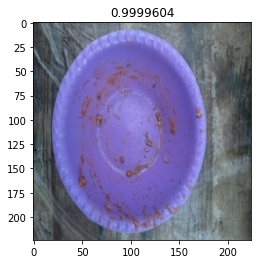

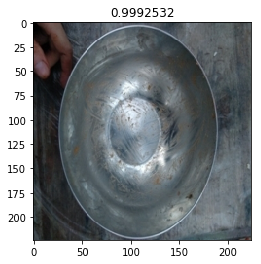

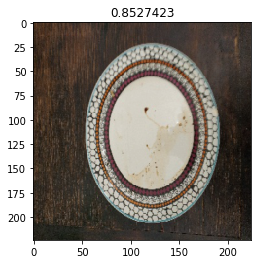

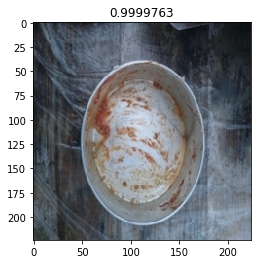

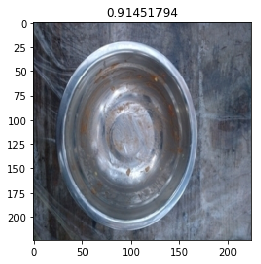

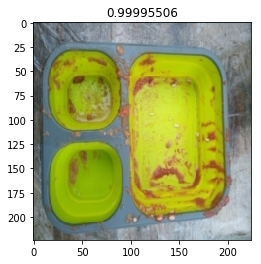

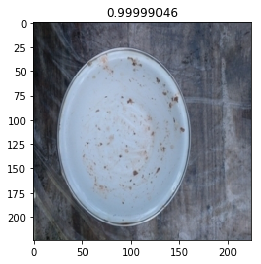

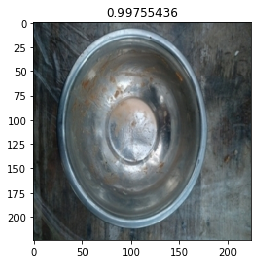

In [465]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [466]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [467]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.9 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,cleaned
0003,dirty
0004,dirty
0005,dirty


In [468]:
submission_df.to_csv('submission.csv')

In [469]:
!rm -rf train val test

In [470]:
train_accuracies = [x.item() for x in train_accuracies]
#val_accuracies = [x.item() for x in val_accuracies]



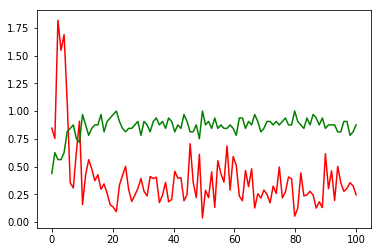

In [471]:
l = len(train_accuracies)

plt.plot(np.linspace(0, l, l), train_losses, color='red')
plt.plot(np.linspace(0, l, l), train_accuracies, color='green')
plt.show()

In [472]:
np.max(train_accuracies), np.argmax(train_accuracies)

(1.0, 21)

In [473]:
np.max(train_accuracies[12:50]), np.argmax(train_accuracies[12:50])

(1.0, 9)